Reference of this kernel:
- https://www.kaggle.com/gzuidhof/reference-model

In [1]:
!pip install shapely -U
!pip install lyft-dataset-sdk

# Our code will generate data, visualization and model checkpoints, they will be persisted to disk in this folder
ARTIFACTS_FOLDER = "./artifacts"

Requirement already up-to-date: shapely in /opt/conda/lib/python3.6/site-packages (1.6.4.post2)
     |████████████████████████████████| 81kB 6.1MB/s 
     |████████████████████████████████| 92kB 6.9MB/s 
  Created wheel for fire: filename=fire-0.2.1-py2.py3-none-any.whl size=103527 sha256=ce35190c1f69474437a9b25bf972f7c526b0e403a7a0b82240a4e47697618c0c
  Stored in directory: /tmp/.cache/pip/wheels/31/9c/c0/07b6dc7faf1844bb4688f46b569efe6cafaa2179c95db821da
Successfully built fire


In [2]:
from datetime import datetime
from functools import partial
import glob
from multiprocessing import Pool

# Disable multiprocesing for numpy/opencv. We already multiprocess ourselves, this would mean every subprocess produces
# even more threads which would lead to a lot of context switching, slowing things down a lot.
import os
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm, tqdm_notebook
import scipy
import scipy.ndimage
import scipy.special
from scipy.spatial.transform import Rotation as R
from mpl_toolkits.mplot3d import Axes3D

from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix

In [3]:
!ln -s /kaggle/input/3d-object-detection-for-autonomous-vehicles/train_images images
!ln -s /kaggle/input/3d-object-detection-for-autonomous-vehicles/train_maps maps
!ln -s /kaggle/input/3d-object-detection-for-autonomous-vehicles/train_lidar lidar

In [4]:
level5data = LyftDataset(data_path='.', json_path='/kaggle/input/3d-object-detection-for-autonomous-vehicles/train_data', verbose=True)
os.makedirs(ARTIFACTS_FOLDER, exist_ok=True)

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 15.6 seconds.
Reverse indexing ...
Done reverse indexing in 7.6 seconds.


In [5]:
type(level5data)

lyft_dataset_sdk.lyftdataset.LyftDataset

In [6]:
demo_scene=level5data.scene[0]
demo_scene

{'log_token': 'da4ed9e02f64c544f4f1f10c6738216dcb0e6b0d50952e158e5589854af9f100',
 'first_sample_token': '24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db21517e4ca92cc8',
 'name': 'host-a101-lidar0-1241893239199111666-1241893264098084346',
 'description': '',
 'last_sample_token': '2346756c83f6ae8c4d1adec62b4d0d31b62116d2e1819e96e9512667d15e7cec',
 'nbr_samples': 126,
 'token': 'da4ed9e02f64c544f4f1f10c6738216dcb0e6b0d50952e158e5589854af9f100'}

Get a sample from the token

In [7]:
demo_sample_data=level5data.get('sample',demo_scene['first_sample_token'])
print(demo_sample_data.keys())
demo_sample_data['data']

dict_keys(['next', 'prev', 'token', 'timestamp', 'scene_token', 'data', 'anns'])


{'CAM_BACK': '542a9e44f2e26221a6aa767c2a9b90a9f692c3aee2edb7145256b61e666633a4',
 'CAM_FRONT_ZOOMED': '9c9bc711d93d728666f5d7499703624249919dd1b290a477fcfa39f41b26259e',
 'LIDAR_FRONT_RIGHT': '8cfae06bc3d5d7f9be081f66157909ff18c9f332cc173d962460239990c7a4ff',
 'CAM_FRONT': 'fb40b3b5b9d289cd0e763bec34e327d3317a7b416f787feac0d387363b4d00f0',
 'CAM_FRONT_LEFT': 'f47a5d143bcebb24efc269b1a40ecb09440003df2c381a69e67cd2a726b27a0c',
 'CAM_FRONT_RIGHT': '5dc54375a9e14e8398a538ff97fbbee7543b6f5df082c60fc4477c919ba83a40',
 'CAM_BACK_RIGHT': 'ae8754c733560aa2506166cfaf559aeba670407631badadb065a9ffe7c337a7d',
 'CAM_BACK_LEFT': '01c0eecd4b56668e949143e02a117b5683025766d186920099d1e918c23c8b4b',
 'LIDAR_TOP': 'ec9950f7b5d4ae85ae48d07786e09cebbf4ee771d054353f1e24a95700b4c4af',
 'LIDAR_FRONT_LEFT': '5c3d79e1cf8c8182b2ceefa33af96cbebfc71f92e18bf64eb8d4e0bf162e01d4'}

In [8]:
demo_lidar_file=level5data.get_sample_data(demo_sample_data['data']['LIDAR_TOP'])[0]

In [9]:
ldp=LidarPointCloud.from_file(demo_lidar_file)

In [10]:
ldp.points

array([[ 1.27406874e+01,  1.27027445e+01,  1.17573252e+01, ...,
         3.08623254e-01,  3.01356822e-01,  3.12240541e-01],
       [-5.82185364e+00, -5.85819721e+00, -5.47204685e+00, ...,
        -8.50992161e-04, -1.88299199e-03, -3.04107601e-03],
       [ 3.74578691e+00,  3.74061990e+00,  3.46782374e+00, ...,
        -1.42656729e-01, -1.39300108e-01, -1.44335106e-01],
       [ 1.00000000e+02,  1.00000000e+02,  1.00000000e+02, ...,
         1.00000000e+02,  1.00000000e+02,  1.00000000e+02]], dtype=float32)

Lidar points is four dimensional: (x,y,z,I)

In [11]:
ldp.points.shape

(4, 107845)

### See the dimension of Lidar points

(-30, 30)

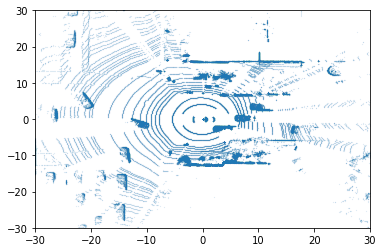

In [12]:
plt.plot(ldp.points[0,:],ldp.points[1,:],'.',markersize=0.1)
plt.xlim([-30,30])
plt.ylim([-30,30])

In [13]:
### Check the intensity values of the lidars

In [14]:
print(ldp.points[3,:].max())
print(ldp.points[3,:].min())

100.0
100.0


som

(-30, 30)

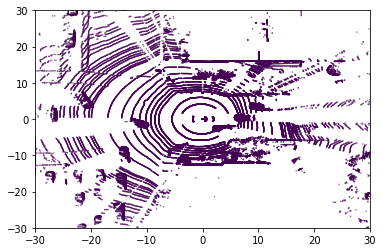

In [15]:
plt.scatter(ldp.points[0,:],ldp.points[1,:],c=ldp.points[3,:],s=0.1)
plt.xlim([-30,30])
plt.ylim([-30,30])

### Plot in 3D

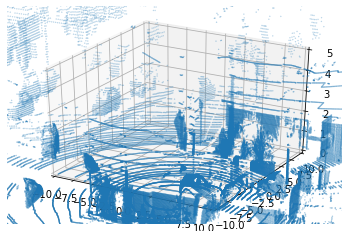

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ldp.points[0,:],ldp.points[1,:],ldp.points[2,:],s=0.1)
ax.set_xlim([-10,10])
ax.set_ylim([-10,10])
ax.set_zlim([0,5])
fig.show()

## Look into annotations

In [17]:
demo_sample_data['anns']

['2a03c42173cde85f5829995c5851cc81158351e276db493b96946882059a5875',
 'c3c663ed5e7b6456ab27f09175743a551b0b31676dae71fbeef3420dfc6c7b09',
 '4193e4bf217c8a0ff598d792bdd9d049b496677d5172e38c1ed22394f20274fb',
 'f543b455c7066d7054ed5218670b4432a3fc7a0f57cadb0cb59aa96e8dd1a135',
 '6ef405e1f47a4a234f0bfeeb559d61c70031af6c47bf2e499a31002f845cd403',
 'db7413e79e7df6de53d801e96e26c494caf1d5b709da85aa7bf04e42c76609f5',
 '40eb44f0b586f2b41fb962adca2c1de351b70f3577a382798db2735564566a33',
 '1ab21da1d6f6d88107a5b067ba1f40929a47ae414b72e8bc17d774f281776cb2',
 '3d7bdcb0c99a5ba50cc74b9b9194fe4f2fdfa82a078c8afa561eec9afad052f9',
 '4e00f88a86a5ae6a015d0a58027a280db2aebf13d4626875c877d23cca553d8d',
 '64e6ea3476f64420c76db21b2fa4ec589def2c05ad97d2574ea63f8f0f7f22c9',
 '7c5adce44d2415e1e2aa21006d6d22393466015a7ae14bf6bef76b28409c93c8',
 '851a84fd2e74affd12c893e445ad66ec3a519ae6a2f4371887fe4d9605be5dd8',
 '53370e3cade07cf9a34adf9212ec2b05b028989087d3ce9edb15d03f4acbb2c1',
 'c5d8880344636ee5711a095f1090ba31

We see a list of tokens.

In [18]:
demo_annotation_token=demo_sample_data['anns'][0]

Use ```get_box()``` to retrieve the annotations

In [19]:
level5data.get_box(demo_annotation_token)

label: nan, score: nan, xyz: [1048.16, 1691.81, -23.30], wlh: [2.00, 5.28, 1.73], rot axis: [0.00, 0.00, 1.00], ang(degrees): 162.29, ang(rad): 2.83, vel: nan, nan, nan, name: car, token: 2a03c42173cde85f5829995c5851cc81158351e276db493b96946882059a5875

Looks like the box is rotated against the z-axis, the coordinates are in world coordinates. To run the transformation we need the position of the ego car, which is recorded in ```ego_pose```
pose_record = self.get("ego_pose", sd_record["ego_pose_token"])

ego_pose_token is stored in sample_data table. Each lidar or camera data is associated with one entry in sample data.

In [20]:
level5data.sample_data[0]

{'is_key_frame': True,
 'prev': 'd190078ec7869ad5c9e5417371aa3b45eb1c22804a0a290ed4695042799b7470',
 'fileformat': 'bin',
 'token': 'ad87e1763749cc8562cca68e2046db128185c80c3e759919f5da448e5d9d9696',
 'timestamp': 1549920983701948.2,
 'next': '8182fb6868baf63c245a4994b7f3034a7d281d1928a7844b7b7159cff3b91a1e',
 'ego_pose_token': 'd90d278f2084ae64c98b0aa2dd8d4f83c023f1313beeaebdcefbf4529209237f',
 'sample_token': 'fd5f1c634b59e3b4e0f7a5c48c768a7d334a63221fced363a2ebac41f465830d',
 'filename': 'lidar/host-a007_lidar1_1233956183701948366.bin',
 'calibrated_sensor_token': '3b463530b5bae9698c9cc803c1731c36abd359a7296e23e81f8c0b546f60e749',
 'sensor_modality': 'lidar',
 'channel': 'LIDAR_TOP'}

In [21]:
demo_lidar_sample_data_entry=level5data.get("sample_data",demo_sample_data['data']['LIDAR_TOP'])
demo_lidar_sample_data_entry

{'is_key_frame': True,
 'prev': '',
 'fileformat': 'bin',
 'token': 'ec9950f7b5d4ae85ae48d07786e09cebbf4ee771d054353f1e24a95700b4c4af',
 'timestamp': 1557858039302414.8,
 'next': 'b2fb6b275352ff1bc8d63cae2ec88561dddb044cae6f8e6ee7ada4ed07d79dc7',
 'ego_pose_token': '2d673d4bee560c77788b91e2ee24503538e74a23e7972e3e0099b92015f76dde',
 'sample_token': '24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db21517e4ca92cc8',
 'calibrated_sensor_token': '82130f5d48b806b62fec95989081337218fbf338ebcc95115d8afcebb305630c',
 'filename': 'lidar/host-a101_lidar1_1241893239302414726.bin',
 'sensor_modality': 'lidar',
 'channel': 'LIDAR_TOP'}

A sample data entry records the ego_pose_token. We use this token to look up the ego_pose table

In [22]:
level5data.get('ego_pose',demo_lidar_sample_data_entry['ego_pose_token'])

{'rotation': [-0.6004078747001647,
  -0.000868287440477653,
  0.0018651459228554272,
  0.7996912850004297],
 'translation': [1007.2332778546752, 1725.4217301399465, -24.58000073380586],
 'token': '2d673d4bee560c77788b91e2ee24503538e74a23e7972e3e0099b92015f76dde',
 'timestamp': 1557858039302414.8}

Now we have collected the information to run the transformation
Coorinate transformation of boxes is performed in ```get_sample_data()```.
So we just use ```get_sample_data()``` again.
The operation transformed the annotation boxes to sensor frame if ```flat_vehicle_coordinates=False```, or transformed the annotation boxes to car frame if ```flat_vehicle_coordinates=True```.

In [23]:
_,boxes,_=level5data.get_sample_data(demo_sample_data['data']['LIDAR_TOP'],flat_vehicle_coordinates=False)

In [24]:
boxes

[label: nan, score: nan, xyz: [-19.02, -48.93, -1.20], wlh: [2.00, 5.28, 1.73], rot axis: [0.01, 0.01, -1.00], ang(degrees): -89.22, ang(rad): -1.56, vel: nan, nan, nan, name: car, token: 2a03c42173cde85f5829995c5851cc81158351e276db493b96946882059a5875,
 label: nan, score: nan, xyz: [-14.68, -17.33, -1.32], wlh: [2.11, 4.76, 1.43], rot axis: [0.01, 0.01, -1.00], ang(degrees): -91.78, ang(rad): -1.60, vel: nan, nan, nan, name: car, token: c3c663ed5e7b6456ab27f09175743a551b0b31676dae71fbeef3420dfc6c7b09,
 label: nan, score: nan, xyz: [16.59, -8.22, -0.64], wlh: [0.58, 0.75, 1.65], rot axis: [0.01, 0.00, -1.00], ang(degrees): 177.60, ang(rad): 3.10, vel: nan, nan, nan, name: pedestrian, token: 4193e4bf217c8a0ff598d792bdd9d049b496677d5172e38c1ed22394f20274fb,
 label: nan, score: nan, xyz: [-27.27, -39.47, -0.53], wlh: [2.83, 5.85, 2.98], rot axis: [0.01, -0.01, -1.00], ang(degrees): 89.62, ang(rad): 1.56, vel: nan, nan, nan, name: truck, token: f543b455c7066d7054ed5218670b4432a3fc7a0f57cad

In [25]:
type(boxes[0])

lyft_dataset_sdk.utils.data_classes.Box

In [26]:
corner_points=boxes[0].corners()
corner_points

array([[-20.00390852, -18.00764512, -17.96713036, -19.96339376,
        -20.07596175, -18.07969836, -18.03918359, -20.03544699],
       [-46.27366501, -46.30109297, -46.29413053, -46.26670257,
        -51.55712356, -51.58455152, -51.57758908, -51.55016112],
       [ -0.34810979,  -0.30132133,  -2.02583143,  -2.07261989,
         -0.37113371,  -0.32434525,  -2.04885535,  -2.0956438 ]])

Use view_points() to project the corners to x-y plane

In [27]:
pts=view_points(corner_points,view=np.eye(2),normalize=False)
pts

array([[-20.00390852, -18.00764512, -17.96713036, -19.96339376,
        -20.07596175, -18.07969836, -18.03918359, -20.03544699],
       [-46.27366501, -46.30109297, -46.29413053, -46.26670257,
        -51.55712356, -51.58455152, -51.57758908, -51.55016112],
       [ -0.34810979,  -0.30132133,  -2.02583143,  -2.07261989,
         -0.37113371,  -0.32434525,  -2.04885535,  -2.0956438 ]])

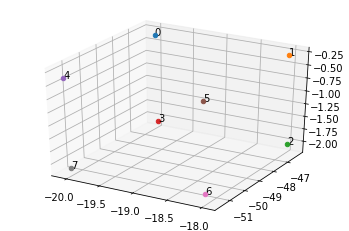

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(8):
    ax.scatter(pts[0,i],pts[1,i],pts[2,i])
    ax.text(pts[0,i],pts[1,i],pts[2,i],s="{}".format(i))
fig.show()

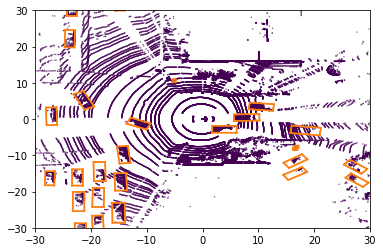

In [29]:
fig = plt.figure()
axis = fig.add_subplot(111)
for box in boxes:
    corners=view_points(box.corners(),view=np.eye(4),normalize=False)
    # Draw the sides
    for i in range(4):
        axis.plot(
            [corners.T[i][0], corners.T[i + 4][0]],
            [corners.T[i][1], corners.T[i + 4][1]],
            color='C1'
        )
    for i in [0,2,4,6]:
        axis.plot(
            [corners.T[i][0], corners.T[i + 1][0]],
            [corners.T[i][1], corners.T[i + 1][1]],
            color='C1'
        )
    #draw_rect(axis,corners.T[:4], color='C0')
    #draw_rect(axis,corners.T[4:], color='C0')
axis.scatter(ldp.points[0,:],ldp.points[1,:],c=ldp.points[3,:],s=0.1)
axis.set_xlim([-30,30])
axis.set_ylim([-30,30])
fig.show()

Or simply using ```box.render()```

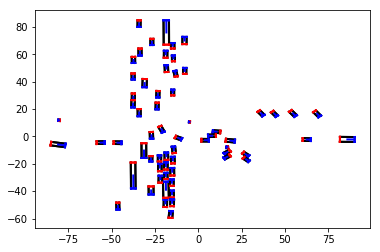

In [30]:
fig = plt.figure()
axis = fig.add_subplot(111)
for box in boxes:
    box.render(axis)